# Importation

In [66]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, RidgeClassifier, RidgeClassifierCV
from sklearn.linear_model import LinearRegression

from tqdm.notebook import tqdm
tqdm.pandas

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

# Load data

In [2]:
employee = pd.read_csv(os.path.join("..","..", "data", "employee.csv"))

In [3]:
employee = employee.drop(["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"], axis = 1)

In [4]:
employee.columns = employee.columns.str.lower()
employee["overtime"] = employee["overtime"].replace("Yes", 1)
employee["overtime"] = employee["overtime"].replace("No", 0)
employee["gender"] = employee["gender"].replace("Male", 1)
employee["gender"] = employee["gender"].replace("Female", 0)

employee = employee.rename(columns = {"attrition" : "y"})

employee["y"] = employee["y"].replace("Yes", 1)
employee["y"] = employee["y"].replace("No", 0)

cat = [var for var in employee.columns if var not in employee.describe().columns.tolist()]

for var in cat:
    
    employee[var] = employee[var].str.lower()
    employee[var] = employee[var].str.replace(' ', '_').astype(str)
    employee[var] = employee[var].str.replace('-', '_').astype(str)
    employee[var] = employee[var].str.replace('&', '_').astype(str)
    employee[var] = employee[var].str.replace('___', '_').astype(str)

y = employee["y"]
X = employee.drop(['y'], axis = 1)

for var in cat :
    
    for val in X[var].value_counts().index.tolist():
        
        X[var] = X[var].replace(val, var+"_"+val)
        
for var in cat :

    dummies = pd.get_dummies(X[var])
    X = X.drop(var,axis = 1)
    X = X.join(dummies)
    
X.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,...,jobrole_laboratory_technician,jobrole_manager,jobrole_manufacturing_director,jobrole_research_director,jobrole_research_scientist,jobrole_sales_executive,jobrole_sales_representative,maritalstatus_divorced,maritalstatus_married,maritalstatus_single
0,41,1102,1,2,2,0,94,3,2,4,...,0,0,0,0,0,1,0,0,0,1
1,49,279,8,1,3,1,61,2,2,2,...,0,0,0,0,1,0,0,0,1,0
2,37,1373,2,2,4,1,92,2,1,3,...,1,0,0,0,0,0,0,0,0,1
3,33,1392,3,4,4,0,56,3,1,3,...,0,0,0,0,1,0,0,0,1,0
4,27,591,2,1,1,1,40,3,1,2,...,1,0,0,0,0,0,0,0,1,0


In [5]:
augmentation =[ ]
for var in X.columns :
    if X[var].unique().tolist() == [0,1] :
        pass
    elif X[var].unique().tolist() ==[1,0]:
        pass
    else :
        augmentation.append(var)

In [6]:
X_nl = X.copy()

for var in augmentation :
    
    X_nl[var+'_squared'] = X_nl[var]**2
    X_nl[var+'_cube'] = X_nl[var]**3

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1176, 49)
(1176,)
(294, 49)
(294,)


In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(X_nl, y, test_size = 0.2, random_state = 42)

In [12]:
print(X_train_nl.shape)
print(y_train_nl.shape)

print(X_test_nl.shape)
print(y_test_nl.shape)

(1176, 95)
(1176,)
(294, 95)
(294,)


In [13]:
scaler = MinMaxScaler()
X_train_nl = scaler.fit_transform(X_train_nl)
X_test_nl = scaler.transform(X_test_nl)

# Estimations by OLS

In [14]:
model = LinearRegression()

In [15]:
model.fit(X_train, y_train)
y_pred_ols = model.predict(X_test)

In [16]:
model.fit(X_train_nl, y_train_nl)
y_pred_ols_nl = model.predict(X_test_nl)

# Estimation by PCR

## Linear 

In [17]:
def PCA(X_train, X_test, n_components):
    global X_train_reduced
    global X_test_reduced
    global num_components
    global sorted_eigenvalue
    # To compute eigen vector and eigen vectors, we first need to compute covariance matrix
    cov_mat = np.cov(X_train , rowvar = False)

    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

    #sort the eigenvalues in descending order
    sorted_index = np.argsort(eigen_values)[::-1]

    sorted_eigenvalue = eigen_values[sorted_index]
    #similarly sort the eigenvectors 
    sorted_eigenvectors = eigen_vectors[:,sorted_index]

    # select the first n eigenvectors, n is desired dimension
    # of our final reduced data.

    eigenvector_subset = sorted_eigenvectors[:,0:n_components]

    #Transform the train data and the test data (from n*k to n*num_components with n number of observation)
    X_train_reduced = np.dot(eigenvector_subset.transpose(),X_train.transpose()).transpose()
    X_test_reduced = np.dot(eigenvector_subset.transpose(),X_test.transpose()).transpose()
    
    num_components = n_components
    return 

In [18]:
PCA(X_train, X_test, 10)

Gets share of the variance explained from the eigen values
Here the first component explain approximately 12% of the variance


In [19]:
eigen_val = sorted_eigenvalue.tolist()
share = []
for number in eigen_val:

    share.append((number / sum(eigen_val))*100)

print("The explained variance by the first 10 principal components is",sum(share[:10]),"%")    
share[:10]

The explained variance by the first 10 principal components is 59.581246990116156 %


[12.09190483282372,
 7.851077817187162,
 6.930602399362009,
 6.343577343801729,
 5.542153517059711,
 5.3080023192975565,
 4.546063264688872,
 4.040093857042666,
 3.5346792632551214,
 3.3930923755976097]

In [20]:
reg = LinearRegression()
reg.fit(X_train_reduced[:,:10], y_train)
y_pred_pcr = reg.predict(X_test_reduced[:,:10])

In [21]:
y_pred_pcr.shape

(294,)

## Non-linear

In [22]:
PCA(X_train_nl, X_test_nl, 10)

Gets share of the variance explained from the eigen values
Here the first component explain approximately 12% of the variance

In [23]:
eigen_val = sorted_eigenvalue.tolist()
share = []
for number in eigen_val:

    share.append((number / sum(eigen_val))*100)

print("The explained variance by the first 10 principal components is",sum(share[:10]),"%")    
share[:10]

The explained variance by the first 10 principal components is 53.34314238611293 %


[7.881057347085784,
 6.790962329398963,
 6.391354475643252,
 5.273745935870884,
 5.240424608333926,
 5.092002251992095,
 4.656962213683607,
 4.291281827997581,
 4.092379412131527,
 3.6329719839753154]

In [24]:
reg = LinearRegression()
reg.fit(X_train_reduced[:,:10], y_train_nl)
y_pred_pcr_nl = reg.predict(X_test_reduced[:,:10])

In [25]:
y_pred_pcr_nl.shape

(294,)

# Estimations by RIDGE

In [26]:
# Train the model and gives the estimated betas
def ridge_train(alpha,X,y) :
    X_with_intercept = np.c_[np.ones((X.shape[0], 1)), X]
    dimension = X_with_intercept.shape[1]
    A = np.identity(dimension)
    A[0, 0] = 0
    A_biased = alpha*A
    betas = np.linalg.inv(X_with_intercept.T.dot(X_with_intercept) +
                                   A_biased).dot(X_with_intercept.T).dot(y)
    return (betas)
# Test the model with the given weights (betas) and output the estimated probabilities
def ridge_fit(betas, X) :
    X_predictor = np.c_[np.ones((X.shape[0], 1)), X]
    y_pred = X_predictor.dot(betas)
    return(y_pred)

## Linear data

### Using GIC 

In [27]:
N = X_train.shape[0]
k = X_train.shape[1]
nobs = N
nobs2 = nobs / 2.0
nobs = float(nobs)

In [28]:
alphas = 5**np.linspace(5,0,100)*0.5

In [29]:
bic_list =[]
aic_list = []

for a in tqdm(alphas, total =len(alphas), desc = 'Progess ' ):
    #Compute the prediction
    weight = ridge_train(a,X_train,y_train)
    predict = ridge_fit(weight, X_test) 
    
    #Recoder 
    predictR = predict.tolist()
    predictR = [0 if x<0 else x for x in predictR]
    
    #Compute the residuals
    res = y_test - predictR
    ssr = np.sum(res ** 2)
    #Compute the log-likelihood
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    #Compute the BIC criterion
    bic = -2*llf +k*np.log(N)
    aic = -2*llf + 2*k 

    bic_list.append(bic)
    aic_list.append(aic)

Progess :   0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
_lambda = pd.DataFrame({
    'lambda' : alphas,
    'bic' : bic_list,
    'aic' : aic_list,
})
filter_minB = _lambda['bic'] == min(_lambda['bic'])
filter_minA = _lambda['aic'] == min(_lambda['aic'])

min_lambdaB = _lambda[filter_minB]
min_lambdaA = _lambda[filter_minA]

In [31]:
print(min_lambdaB)
print(min_lambdaA)

      lambda         bic         aic
65  7.929057 -662.300112 -910.723944
      lambda         bic         aic
65  7.929057 -662.300112 -910.723944


In [32]:
weight = ridge_train(min_lambdaA.iloc[0,0],X_train,y_train)
y_pred0 = ridge_fit(weight, X_test)

In [33]:
y_pred0.shape

(294,)

### Using cross-validation to optimize the SSR

In [ ]:
# Definition of the alphas (lambda) to test
alphas = 10**np.linspace(5,0,1000)*0.5

In [34]:
k=5
kf = KFold(n_splits=k, random_state=None)

ssr_list = []
for a in tqdm(alphas, total =len(alphas), desc = 'Progress ' ):
    ssr_score = []
    for train_index , test_index in kf.split(X):
        Xtrain , Xtest = X.iloc[train_index,:],X.iloc[test_index,:]
        ytrain , ytest = y[train_index] , y[test_index]
        #Compute the prediction
        weight = ridge_train(a,Xtrain,ytrain)
        predict = ridge_fit(weight, Xtest) 
        #Recoder 
        predictR = predict.tolist()
        predictR = [0 if x<0 else x for x in predictR]
        
      #Compute the residuals
        res = ytest - predictR
        ssr = np.sum(res ** 2)
        ssr_score.append(ssr)
        
    avg_ssr_score = sum(ssr_score)/k
    ssr_list.append(avg_ssr_score)

Progress :   0%|          | 0/100 [00:00<?, ?it/s]

In [35]:
_lambda = pd.DataFrame({
    'lambda' : alphas,
    'ssr' : ssr_list
})
filter_min = _lambda['ssr'] == min(_lambda['ssr'])
min_lambda = _lambda[filter_min]
min_lambda

,lambda,ssr
70,5.280973,30.084131


In [36]:
weight = ridge_train(min_lambda.iloc[0,0],X_train,y_train)
y_pred1 = ridge_fit(weight, X_test)
#y_pred_train = ridge_fit(weight, X_train)

In [37]:
y_pred1.shape

(294,)

### SKLEARN

In [67]:
# Found the alpha
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train, y_train)
print("The optimal alpha seems to be :",round(ridgecv.alpha_,4))
# Train the model
Rclf = Ridge(alpha = ridgecv.alpha_)
trained_Rclf = Rclf.fit(X_train,y_train)
# Prediction
y_pred2 = trained_Rclf.predict(X_test)
#y_pred_train = trained_Rclf.predict(X_train)

The optimal alpha seems to be : 11.905


In [77]:
SE = np.std(y_pred2)/np.sqrt(49)

In [80]:
estimations = pd.DataFrame({
    'var':X.columns,
    'estimates' : ridgecv.coef_
})
estimations['t-stat'] = estimations['estimates']/SE

In [85]:
estimations[abs(estimations['t-stat']) > 1.96]

,var,estimates,t-stat
0,age,-0.110726,-4.403068
2,distancefromhome,0.082337,3.274182
4,environmentsatisfaction,-0.101043,-4.018009
7,jobinvolvement,-0.142875,-5.681500
9,jobsatisfaction,-0.105004,-4.175521
12,numcompaniesworked,0.141164,5.613448
13,overtime,0.227249,9.036661
18,totalworkingyears,-0.070278,-2.794621
19,trainingtimeslastyear,-0.052131,-2.072997
20,worklifebalance,-0.080910,-3.217421


In [68]:
y_pred2.shape

(294,)

# LASSO

In [40]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 10000)
lassocv.fit(X_train, y_train)
# Optimal alpha
print("The optimal alpha seems to be : ", round(lassocv.alpha_,4))

The optimal alpha seems to be :  0.0013


In [41]:
lasso = Lasso(max_iter = 100000)
# Train the model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
# Prediction
y_pred3 = lasso.predict(X_test)
y_pred_train = lasso.predict(X_train)

In [42]:
y_pred3.shape

(294,)

## Non-linear data

### Using GIC

In [43]:
N = X_train_nl.shape[0]
k = X_train_nl.shape[1]
nobs = N
nobs2 = nobs / 2.0
nobs = float(nobs)

In [44]:
bic_list =[]
aic_list = []

for a in tqdm(alphas, total =len(alphas), desc = 'Progess ' ):
    #Compute the prediction
    weight = ridge_train(a,X_train_nl,y_train_nl)
    predict = ridge_fit(weight, X_test_nl) 
    
    #Recoder 
    predictR = predict.tolist()
    predictR = [0 if x<0 else x for x in predictR]
    
    #Compute the residuals
    res = y_test_nl - predictR
    ssr = np.sum(res ** 2)
    #Compute the log-likelihood
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    #Compute the BIC criterion
    bic = -2*llf +k*np.log(N)
    aic = -2*llf + 2*k 

    bic_list.append(bic)
    aic_list.append(aic)

Progess :   0%|          | 0/100 [00:00<?, ?it/s]

In [45]:
_lambda = pd.DataFrame({
    'lambda' : alphas,
    'bic' : bic_list,
    'aic' : aic_list,
})
filter_minB = _lambda['bic'] == min(_lambda['bic'])
filter_minA = _lambda['aic'] == min(_lambda['aic'])

min_lambdaB = _lambda[filter_minB]
min_lambdaA = _lambda[filter_minA]

In [46]:
print(min_lambdaB)
print(min_lambdaA)

      lambda         bic         aic
91  0.958037 -368.906669 -850.544711
      lambda         bic         aic
91  0.958037 -368.906669 -850.544711


In [47]:
weight = ridge_train(min_lambdaA.iloc[0,0],X_train_nl,y_train_nl)
y_pred01 = ridge_fit(weight, X_test_nl)

In [48]:
y_pred01.shape

(294,)

### Using cross-validation to optimize the SSR

In [49]:
k=10
kf = KFold(n_splits=k, random_state=None)

ssr_list = []
for a in tqdm(alphas, total =len(alphas), desc = 'Progess ' ):
    ssr_score = []
    for train_index , test_index in kf.split(X_nl):
        Xtrain_nl , Xtest_nl = X_nl.iloc[train_index,:],X_nl.iloc[test_index,:]
        ytrain_nl , ytest_nl = y[train_index] , y[test_index]
        #Compute the prediction
        weight = ridge_train(a,Xtrain_nl,ytrain_nl)
        predict = ridge_fit(weight, Xtest_nl) 
        #Recoder 
        predictR = predict.tolist()
        predictR = [0 if x<0 else x for x in predictR]
        #Compute the residuals
        res = ytest_nl - predictR
        ssr = np.sum(res ** 2)
        ssr_score.append(ssr)
    avg_ssr_score = sum(ssr_score)/k
    ssr_list.append(avg_ssr_score)

Progess :   0%|          | 0/100 [00:00<?, ?it/s]

In [50]:
_lambda = pd.DataFrame({
    'lambda' : alphas,
    'ssr' : ssr_list
})
filter_min = _lambda['ssr'] == min(_lambda['ssr'])
min_lambda = _lambda[filter_min]
min_lambda

,lambda,ssr
99,0.5,14.258152


In [51]:
weight = ridge_train(min_lambda.iloc[0,0],X_train_nl,y_train_nl)
y_pred4 = ridge_fit(weight, X_test_nl)
#y_pred_train = ridge_fit(weight, X_train_nl)

In [52]:
y_pred4.shape

(294,)

### SKLEARN

In [53]:
# Found the alpha
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train_nl, y_train_nl)
print("The optimal alpha seems to be :",round(ridgecv.alpha_,4))
# Train the model
Rclf = Ridge(alpha = ridgecv.alpha_)
trained_Rclf = Rclf.fit(X_train_nl,y_train_nl)
# Prediction
y_pred5 = trained_Rclf.predict(X_test_nl)
#y_pred_train = trained_Rclf.predict(X_train_nl)

The optimal alpha seems to be : 0.5


### Lasso

In [54]:
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 10000)
lassocv.fit(X_train_nl, y_train_nl)
# Optimal alpha
print("The optimal alpha seems to be : ", round(lassocv.alpha_,4))

The optimal alpha seems to be :  1562.5


In [55]:
lasso = Lasso(max_iter = 100000)
# Train the model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train_nl, y_train_nl)
# Prediction
y_pred6 = lasso.predict(X_test_nl)
#y_pred_train = lasso.predict(X_train_nl)

# Use metrics to compare the predictions

## Use the recall-precision curve to tune the threshold

In [56]:
  from sklearn.metrics import precision_recall_curve

In [57]:
def recall_precission(y_test,y_pred,model):
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    fscore[np.isnan(fscore)] = 0
    #print(fscore)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    optimal_threshold = thresholds[ix]

    # plot the roc curve for the model
    plt.plot(recall, precision, marker='.', label=model)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()
    
    print("\nTEST")
    print('Best Threshold=%f, F-Score=%.3f' % (optimal_threshold, fscore[ix]))
    y_pred2= np.where(y_pred <= optimal_threshold , 0, 1)
    cm = confusion_matrix(y_test, y_pred2)
    print("Confusion matrix \n" , cm)
    precision = cm[1,1]/sum(cm[:,1])
    print("\nPrecision : " + str(precision))
    recall = cm[1,1]/sum(cm[1,:])
    print("Recall : " + str(recall))
    f1 = 2*((precision*recall)/(precision+recall))
    print("F1 : " + str(f1))
    

### OLS evaluation

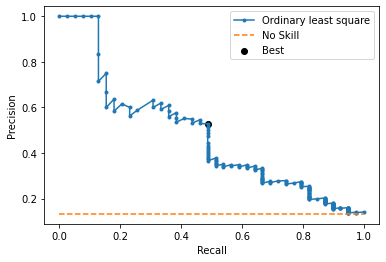


TEST
Best Threshold=0.399414, F-Score=0.507
Confusion matrix 
 [[239  16]
 [ 21  18]]

Precision : 0.5294117647058824
Recall : 0.46153846153846156
F1 : 0.4931506849315069


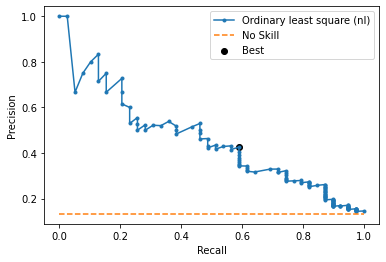


TEST
Best Threshold=0.390625, F-Score=0.495
Confusion matrix 
 [[224  31]
 [ 17  22]]

Precision : 0.41509433962264153
Recall : 0.5641025641025641
F1 : 0.4782608695652174


In [58]:
ols_1 = recall_precission(y_test,y_pred_ols,'Ordinary least square')
ols_2 = recall_precission(y_test_nl,y_pred_ols_nl,'Ordinary least square (nl)')

### PCR evaluation

<ipython-input-57-f51ce60b20a7>:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


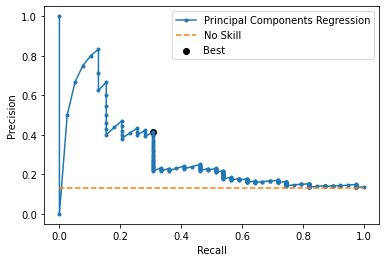


TEST
Best Threshold=0.341029, F-Score=0.353
Confusion matrix 
 [[238  17]
 [ 28  11]]

Precision : 0.39285714285714285
Recall : 0.28205128205128205
F1 : 0.32835820895522383


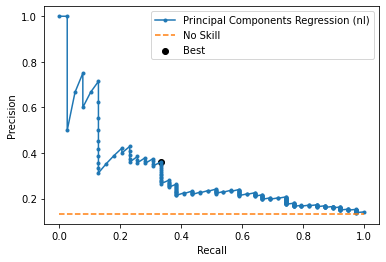


TEST
Best Threshold=0.309350, F-Score=0.347
Confusion matrix 
 [[232  23]
 [ 27  12]]

Precision : 0.34285714285714286
Recall : 0.3076923076923077
F1 : 0.3243243243243243


In [59]:
pcr_1 = recall_precission(y_test,y_pred_pcr,'Principal Components Regression')
pcr_2 = recall_precission(y_test_nl,y_pred_pcr_nl,'Principal Components Regression (nl)')

### Penalisation evaluation

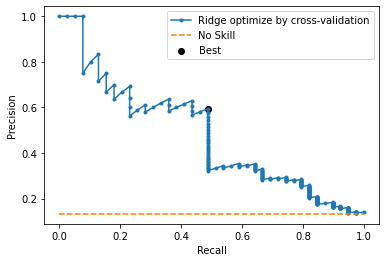


TEST
Best Threshold=0.395724, F-Score=0.535
Confusion matrix 
 [[242  13]
 [ 21  18]]

Precision : 0.5806451612903226
Recall : 0.46153846153846156
F1 : 0.5142857142857143


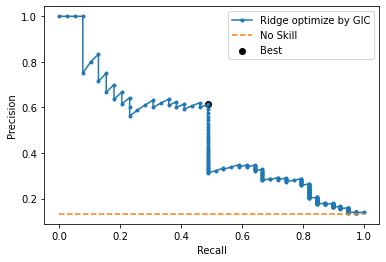


TEST
Best Threshold=0.392337, F-Score=0.543
Confusion matrix 
 [[243  12]
 [ 21  18]]

Precision : 0.6
Recall : 0.46153846153846156
F1 : 0.5217391304347826


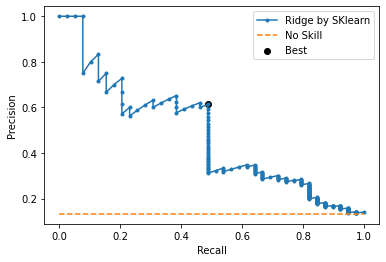


TEST
Best Threshold=0.388089, F-Score=0.543
Confusion matrix 
 [[243  12]
 [ 21  18]]

Precision : 0.6
Recall : 0.46153846153846156
F1 : 0.5217391304347826


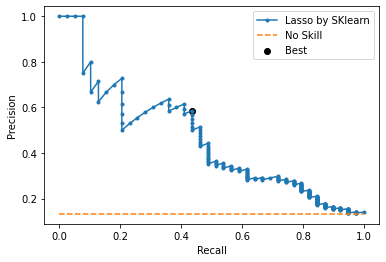


TEST
Best Threshold=0.387042, F-Score=0.500
Confusion matrix 
 [[243  12]
 [ 23  16]]

Precision : 0.5714285714285714
Recall : 0.41025641025641024
F1 : 0.47761194029850745


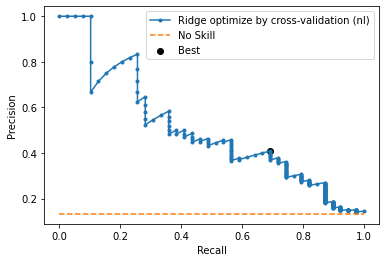


TEST
Best Threshold=0.316277, F-Score=0.514
Confusion matrix 
 [[216  39]
 [ 13  26]]

Precision : 0.4
Recall : 0.6666666666666666
F1 : 0.5


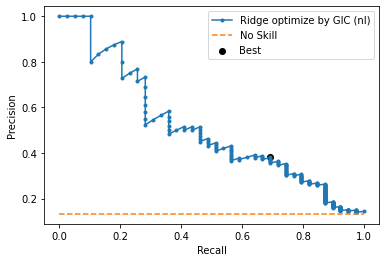


TEST
Best Threshold=0.303040, F-Score=0.491
Confusion matrix 
 [[211  44]
 [ 13  26]]

Precision : 0.37142857142857144
Recall : 0.6666666666666666
F1 : 0.4770642201834863


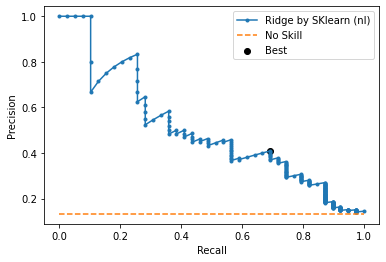


TEST
Best Threshold=0.316277, F-Score=0.514
Confusion matrix 
 [[216  39]
 [ 13  26]]

Precision : 0.4
Recall : 0.6666666666666666
F1 : 0.5


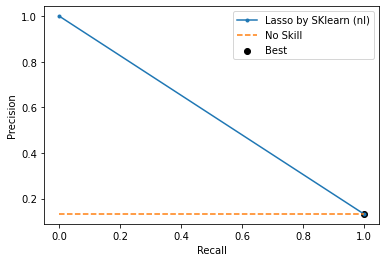


TEST
Best Threshold=0.168367, F-Score=0.234
Confusion matrix 
 [[255   0]
 [ 39   0]]

Precision : nan
Recall : 0.0
F1 : nan


<ipython-input-57-f51ce60b20a7>:28: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = cm[1,1]/sum(cm[:,1])


In [60]:
recall_1 = recall_precission(y_test,y_pred1,'Ridge optimize by cross-validation')
recall_2 = recall_precission(y_test,y_pred0,'Ridge optimize by GIC')
recall_3 = recall_precission(y_test,y_pred2,'Ridge by SKlearn')
recall_4 = recall_precission(y_test,y_pred3, 'Lasso by SKlearn')
recall_5 = recall_precission(y_test_nl,y_pred4,'Ridge optimize by cross-validation (nl)')
recall_6 = recall_precission(y_test_nl,y_pred01,'Ridge optimize by GIC (nl)')
recall_7 = recall_precission(y_test_nl,y_pred5,'Ridge by SKlearn (nl)')
recall_8 = recall_precission(y_test_nl,y_pred6, 'Lasso by SKlearn (nl)')

In [61]:
def recall (y_test,y_pred,model) :
    
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    # plot the roc curve for the model
    recall_plot = plt.plot(recall, precision, marker='.', label=model)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(bbox_to_anchor=(0.5, -0.4), loc='center', ncol=1)
    # show the plot
    return(recall_plot)

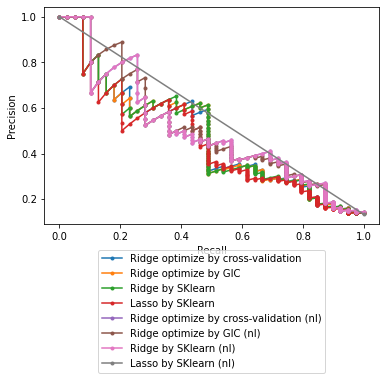

In [62]:
recall_1 = recall(y_test,y_pred1,'Ridge optimize by cross-validation')
recall_2 = recall(y_test,y_pred0,'Ridge optimize by GIC')
recall_3 = recall(y_test,y_pred2,'Ridge by SKlearn')
recall_4 = recall(y_test,y_pred3, 'Lasso by SKlearn')
recall_5 = recall(y_test_nl,y_pred4,'Ridge optimize by cross-validation (nl)')
recall_6 = recall(y_test_nl,y_pred01,'Ridge optimize by GIC (nl)')
recall_7 = recall(y_test_nl,y_pred5,'Ridge by SKlearn (nl)')
recall_8 = recall(y_test_nl,y_pred6, 'Lasso by SKlearn (nl)')

### Sum-up

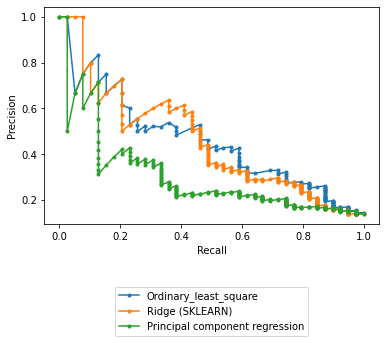

In [65]:
recall_ols = recall(y_test_nl,y_pred_ols_nl, 'Ordinary_least_square')
recall_ridge = recall(y_test,y_pred3,'Ridge (SKLEARN)')
recall_pcr = recall(y_test,y_pred_pcr_nl, 'Principal component regression')